<a href="https://colab.research.google.com/github/ianhstudent/ColabMLNotebook/blob/JPRSubmission/NoResamp_ANN_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
!pip install shap

import io
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.utils import compute_class_weight
from tensorflow import keras
from tensorflow.keras import layers
import shap
import matplotlib.pyplot as plt
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 3.5 MB/s eta 0:00:00


In [ ]:
from google.colab import files
fn = files.upload()


Saving Term&Preterm_AllSamples_20240404.csv to Term&Preterm_AllSamples_20240404.csv


In [ ]:
# Adjust to read the uploaded file (name should already be provided after the upload)
data = pd.read_csv(io.BytesIO(fn['Term&Preterm_AllSamples_20240404.csv']))

print(data)

     Group       Thymine  4-Aminohippuric acid  5-Aminopentanamide  \
0        0  16148.476140           8415.820791         6905.938406   
1        0  24901.941100           8256.863739        14832.413540   
2        0   7641.399579           3974.474322         8179.276112   
3        0  14861.731150           3597.318170         7409.747105   
4        0  24297.212620           1230.643149          999.343056   
..     ...           ...                   ...                 ...   
145      1  12481.279420           6060.336998        11573.555520   
146      1  10958.468430           4564.755171         2608.258373   
147      1   9084.021333           1522.630155         1265.233521   
148      1  29612.010220           3227.926086         1788.734921   
149      1  12011.645970           1581.129616         1996.768786   

     5-Hydroxyoctanoylcarnitine (C10:0-OH)  Acetylcarnitine  Acetylcholine  \
0                             542037.60150     18407.927030    66215.74512   
1  

In [ ]:
X = data.drop(columns=['Group'])  # All columns except 'Group'
y = data['Group']  # Replace with your target column


In [ ]:
n_features = X.shape[1]
print(n_features)

181


In [ ]:
# Exclude features with over 50% missing values
missing_threshold = 0.5  # 50% threshold
X = X.loc[:, X.isna().mean() <= missing_threshold]

n_features = X.shape[1]
print(n_features)

175


In [ ]:
# Handle missing values in the remaining features using KNN imputation
imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors as needed
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Epoch 1/100
4/4 - 4s - loss: 0.7240 - accuracy: 0.5083 - val_loss: 0.7333 - val_accuracy: 0.5000 - 4s/epoch - 971ms/step
Epoch 2/100
4/4 - 0s - loss: 0.6214 - accuracy: 0.6250 - val_loss: 0.6859 - val_accuracy: 0.5667 - 95ms/epoch - 24ms/step
Epoch 3/100
4/4 - 0s - loss: 0.5549 - accuracy: 0.7250 - val_loss: 0.6531 - val_accuracy: 0.5667 - 76ms/epoch - 19ms/step
Epoch 4/100
4/4 - 0s - loss: 0.5070 - accuracy: 0.8083 - val_loss: 0.6388 - val_accuracy: 0.5667 - 162ms/epoch - 40ms/step
Epoch 5/100
4/4 - 0s - loss: 0.4731 - accuracy: 0.8250 - val_loss: 0.6430 - val_accuracy: 0.5667 - 139ms/epoch - 35ms/step
Epoch 6/100
4/4 - 0s - loss: 0.4353 - accuracy: 0.8583 - val_loss: 0.6205 - val_accuracy: 0.5333 - 84ms/epoch - 21ms/step
Epoch 7/100
4/4 - 0s - loss: 0.4066 - accuracy: 0.8917 - val_loss: 0.6116 - val_accuracy: 0.5667 - 84ms/epoch - 21ms/step
Epoch 8/100
4/4 - 0s - loss: 0.3785 - accuracy: 0.9083 - val_loss: 0.6042 - val_accuracy: 0.6333 - 90ms/epoch - 23ms/step
Epoch 9/100
4/4 - 0s - 

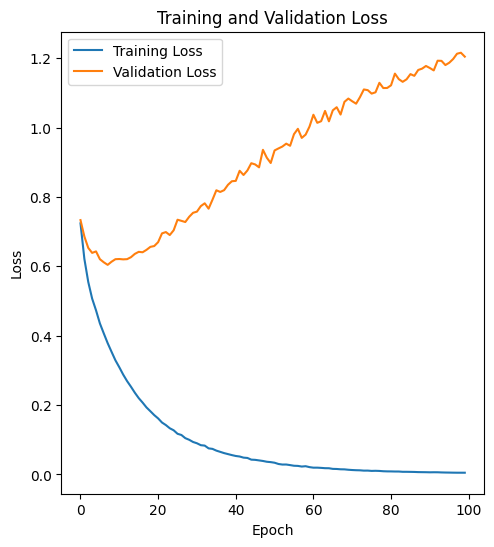

1/1 [==============================] - 0s 89ms/step


PermutationExplainer explainer: 31it [00:10,  2.68s/it]


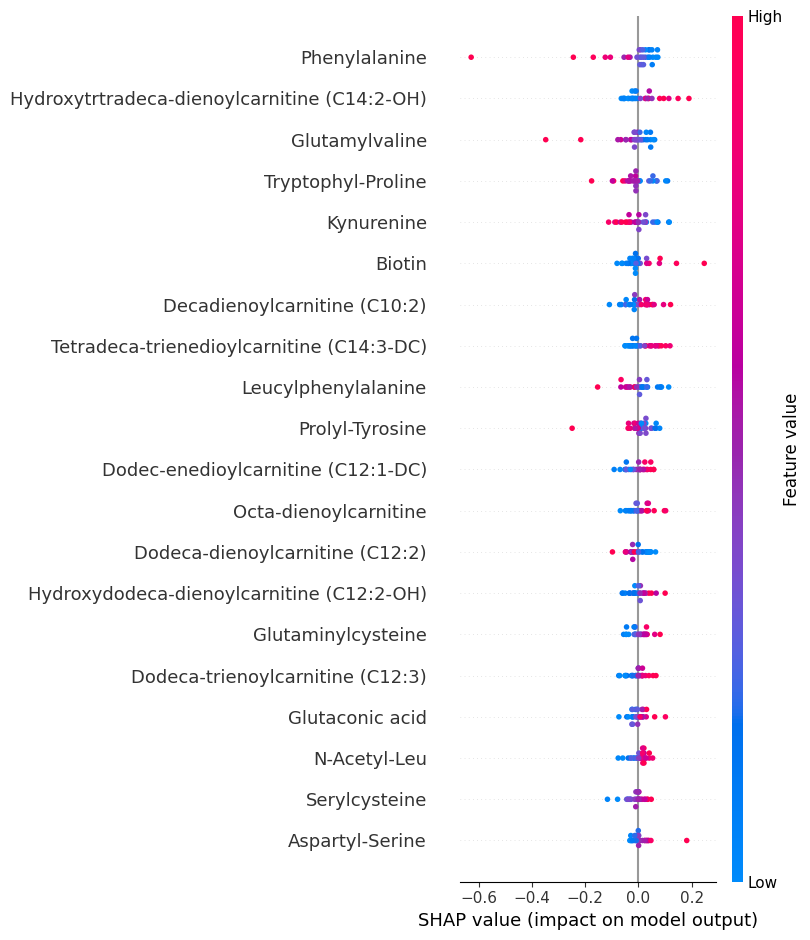

In [ ]:
from tensorflow.keras.optimizers import Adam

# Standardize the input features via Z-score (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Create a simple CNN model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Assuming binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)


# Fit the model with history
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, class_weight={0: class_weights[0], 1: class_weights[1]}, verbose=2, validation_data=(X_test_scaled, y_test))

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

# Make predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.round(y_pred_prob)  # Convert probabilities to binary predictions

# Use SHAP to explain feature importances
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled)

# Summarize the feature importance values
shap.summary_plot(shap_values, X_test_scaled, feature_names=data.columns)


1/1 [==============================] - 0s 20ms/step


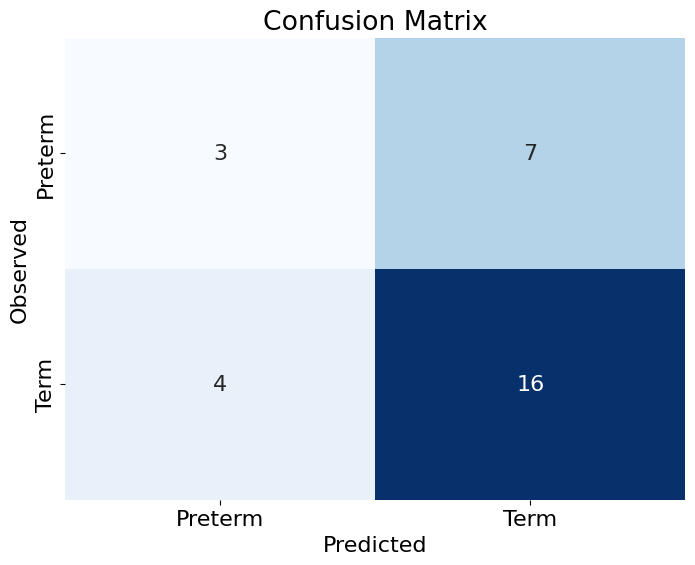

In [ ]:
# Make predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)  # Rounding probabilities to binary predictions

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})  # Adjust font size as needed
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Preterm", "Term"], yticklabels=["Preterm", "Term"])


plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 24ms/step - loss: 1.2046 - accuracy: 0.6333
Test Accuracy: 0.63
1/1 [==============================] - 0s 23ms/step
AUC: 0.69


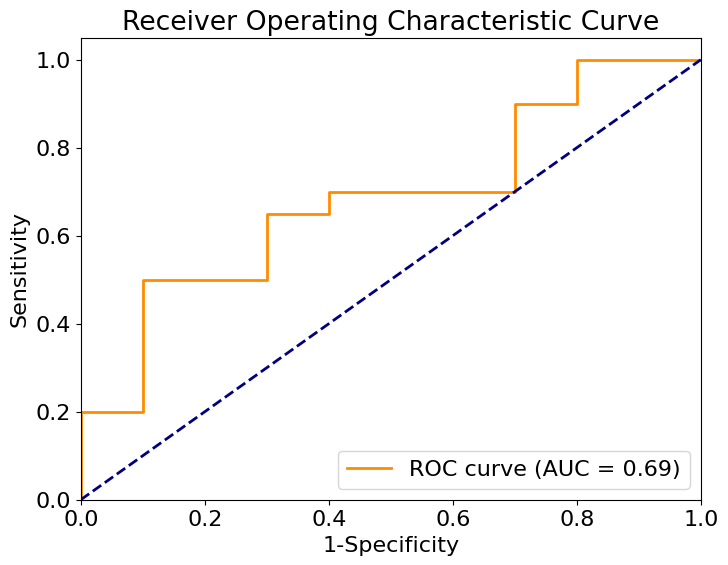

In [ ]:
# Performance Evaluation

# Use the transformed test data directly for evaluation
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Make predictions on the test data
y_pred = model.predict(X_test_scaled)

# Convert predicted probabilities to class labels (0 or 1)
y_pred_binary = np.argmax(y_pred, axis=1)


# Calculate AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.2f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})  # Adjust font size as needed
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()


1/1 [==============================] - 0s 40ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


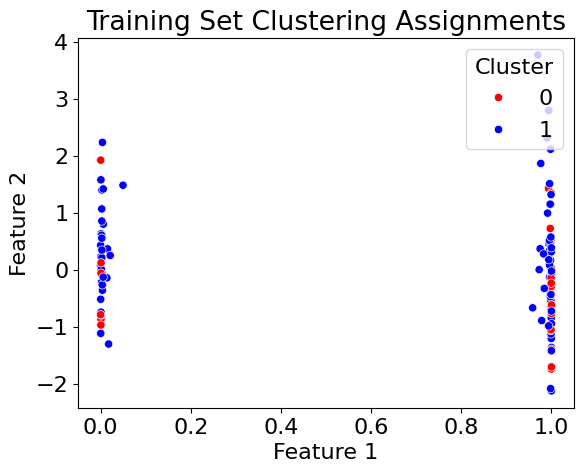

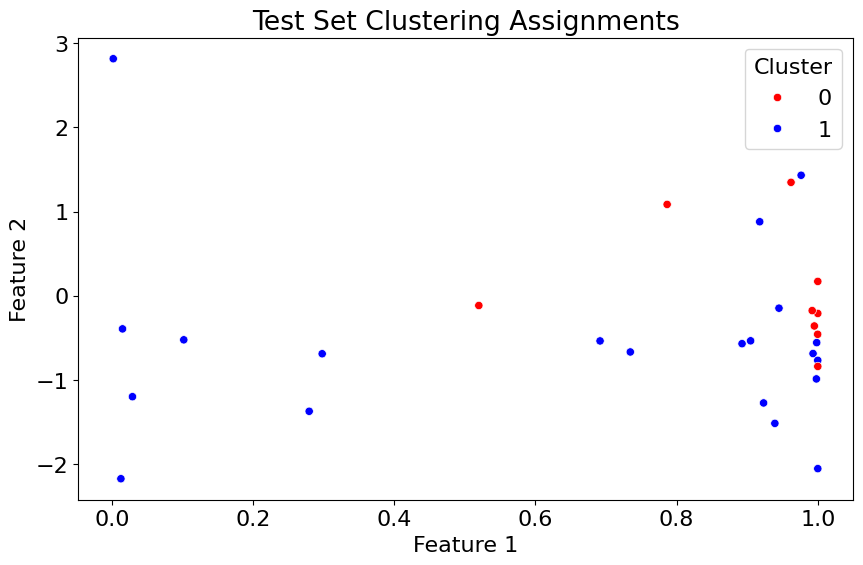

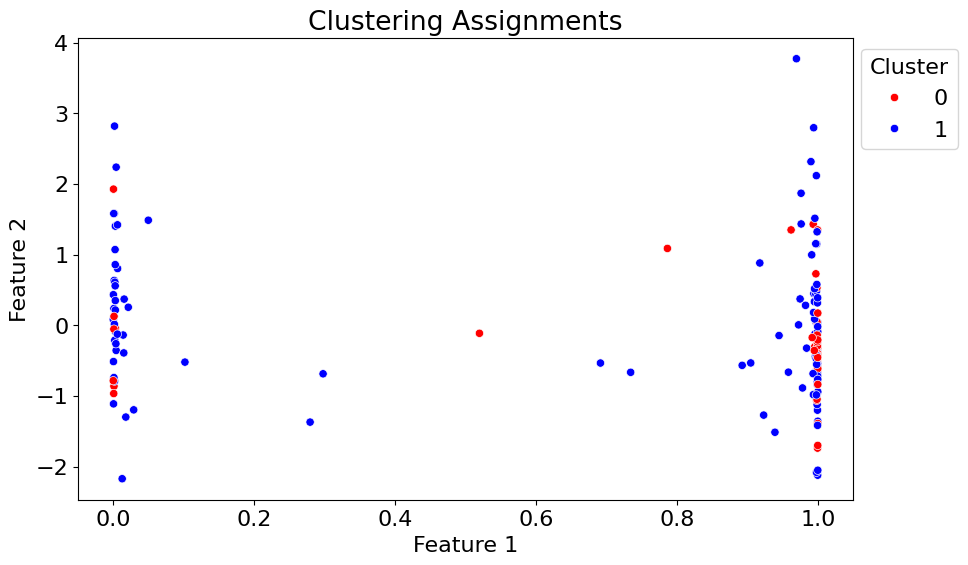

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

# Assuming model.predict_proba(X_train) and model.predict_proba(X_test) return the predicted probabilities for each class for X_train and X_test respectively
y_train_proba = model.predict(X_train_scaled).flatten()  # Probabilities of the positive class
y_test_proba = model.predict(X_test_scaled).flatten()

# Create a feature matrix using the scaled predicted probabilities
X_train_cluster = np.column_stack((y_train_proba, X_train_scaled))
X_test_cluster = np.column_stack((y_test_proba, X_test_scaled))

# Define the number of clusters (you may adjust this based on your dataset)
n_clusters = 2


# Perform K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
train_cluster_labels = kmeans.fit_predict(X_train_cluster)
test_cluster_labels = kmeans.predict(X_test_cluster)

cluster_colors = ['red', 'blue']

# Visualize clustering assignments
sns.scatterplot(x=X_train_cluster[:, 0], y=X_train_cluster[:, 1], hue=train_cluster_labels, palette=cluster_colors, legend='full')
plt.title('Training Set Clustering Assignments')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Cluster', loc='upper right')
plt.grid(False)
plt.show()
3
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test_cluster[:, 0], y=X_test_cluster[:, 1], hue=test_cluster_labels, palette=cluster_colors, legend='full')
plt.title('Test Set Clustering Assignments')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Cluster', loc='upper right')
plt.grid(False)
plt.show()

# Combine the features and cluster labels for both training and test sets
X_combined = np.concatenate((X_train_cluster[:, :2], X_test_cluster[:, :2]))  # Concatenate first two columns
cluster_labels_combined = np.concatenate((train_cluster_labels, test_cluster_labels))

plt.rcParams.update({'font.size': 16})
# Visualize clustering assignments for combined data
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_combined[:, 0], y=X_combined[:, 1], hue=cluster_labels_combined, palette=cluster_colors, legend='full')
plt.title('Clustering Assignments')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Cluster', loc='upper right',bbox_to_anchor=(1.15, 1))
plt.grid(False)
plt.show()


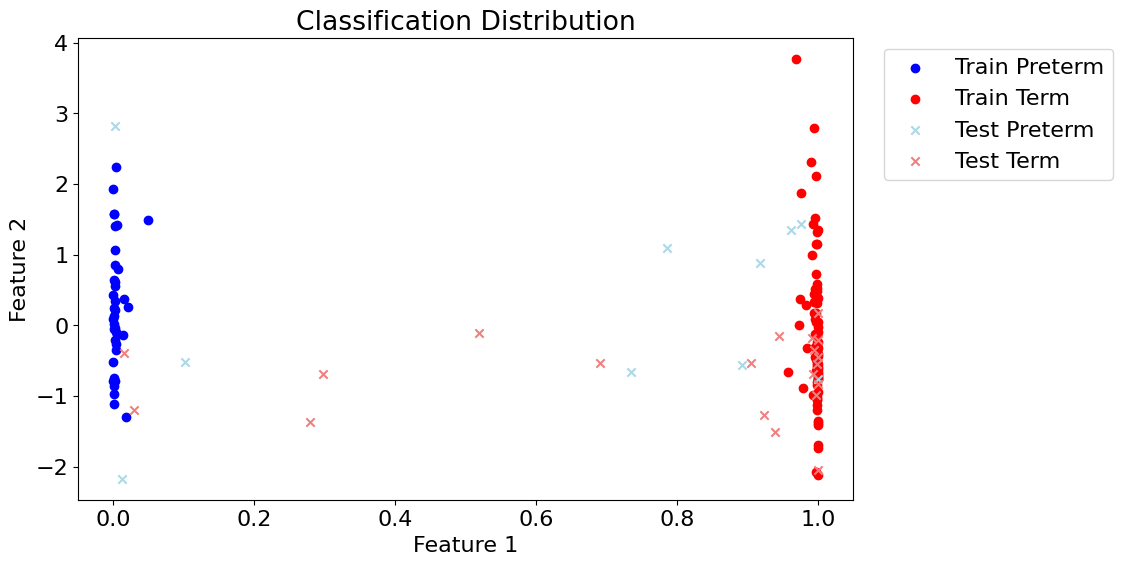

In [ ]:
import matplotlib.pyplot as plt

# Separate train set based on class
X_train_class_0 = X_train_cluster[y_train == 0]
X_train_class_1 = X_train_cluster[y_train == 1]

# Separate test set based on class
X_test_class_0 = X_test_cluster[y_test == 0]
X_test_class_1 = X_test_cluster[y_test == 1]

# Create scatter plots
plt.figure(figsize=(10, 6))

plt.rcParams.update({'font.size': 16})  # Adjust font size as needed for all figures

plt.scatter(X_train_class_0[:, 0], X_train_class_0[:, 1], color='blue', label='Train Preterm')
plt.scatter(X_train_class_1[:, 0], X_train_class_1[:, 1], color='red', label='Train Term')
plt.scatter(X_test_class_0[:, 0], X_test_class_0[:, 1], color='lightblue', marker='x', label='Test Preterm')
plt.scatter(X_test_class_1[:, 0], X_test_class_1[:, 1], color='lightcoral', marker='x', label='Test Term')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Classification Distribution')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
plt.show()


In [ ]:
# Check with Cross Validation via KNN
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# Reshape the data for CNN input (treat it as an image with one channel per feature)
input_shape = (X_train_scaled.shape[1], 1, 1)  # One channel (feature), one pixel
X_train_cnn = X_train_scaled.reshape((-1, *input_shape))
X_test_cnn = X_test_scaled.reshape((-1, *input_shape))

# Extract features from the trained CNN model
cnn_model = keras.Model(inputs=model.input, outputs=model.get_layer('dense_2').output)  # Assuming 'dense_4' is the layer before the final output layer
X_train_features = cnn_model.predict(X_train_scaled)
X_test_features = cnn_model.predict(X_test_scaled)

# Standardize the extracted features
scaler = StandardScaler()
X_train_features_scaled = scaler.fit_transform(X_train_features)
X_test_features_scaled = scaler.transform(X_test_features)

# Create a KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors

# Perform k-fold cross-validation
cv_scores = cross_val_score(knn, X_train_features_scaled, y_train, cv=10)  # 5-fold cross-validation

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

# Fit the KNN model on the entire training data
knn.fit(X_train_features_scaled, y_train)

# Evaluate the KNN model on the test data
X_test_features_scaled = scaler.transform(X_test_features)  # Standardize test features
test_accuracy = knn.score(X_test_features_scaled, y_test)
print("Test accuracy:", test_accuracy)

1/1 [==============================] - 0s 37ms/step
Cross-validation scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean CV accuracy: 1.0
Test accuracy: 0.6333333333333333
